In [1]:
# Install required libs
#!pip install -U segmentation-models-pytorch --user
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-zfi_426r
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-zfi_426r
     |████████████████████████████████| 61kB 9.7MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.0-cp36-none-any.whl size=42616 sha256=468e17653a81fe9f1cf893cdba415e79a88bce14dbf7229ef7b1fa540ede355e
  Stored in directory: /tmp/pip-ephem-wheel-cache-s0b2qxsp/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=2ffa58111f7024277a95829189d0352bdcd54e11bbdf814a4e1d20a5321d4903
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.5.1-cp36-none-any.whl size=11768 sha256=8919010d00ecc26ae38b1d3c62c

In [0]:
#!pip uninstall -y segmentation-models-pytorch

Uninstalling segmentation-models-pytorch-0.0.3:
  Successfully uninstalled segmentation-models-pytorch-0.0.3


## Loading data

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import PIL
from PIL import Image

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class SegmentationDataset(Dataset):

    def __init__(self, datafolder, datatype='train', transform = torchvision.transforms.Compose(
                  [transforms.Resize(512),
                   torchvision.transforms.Grayscale(num_output_channels=3),
                   torchvision.transforms.ToTensor()])):          
        self.datafolder = datafolder
        self.image_files_list = None
      
        self.image_files_list = [s for s in os.listdir(datafolder) if 
                                '.jpg' in s] 
        self.label_files_list = [None] * len(self.image_files_list)
        for i in range(len(self.image_files_list)): 
          s = self.image_files_list[i]
          s = s.replace("sat", "mask")
          s = s.replace("jpg", "png")
          self.label_files_list[i] = s

        self.transform = transform
        self.transform_label = torchvision.transforms.Compose(
            [transforms.Resize(512),
                   torchvision.transforms.Grayscale(num_output_channels=1),
                   torchvision.transforms.ToTensor()]
        )

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = Image.open(img_name)
        image = self.transform(image)

        label_name = os.path.join(self.datafolder, self.label_files_list[idx])
        label = Image.open(label_name)
        label = self.transform_label(label)
        
        return image, label

## Create model and train

In [0]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [0]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['road']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda:0'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 92.1MB/s]


In [0]:
train_dir = '/content/drive/My Drive/cs461-final-project/data/roads/data_split/train'
valid_dir = '/content/drive/My Drive/cs461-final-project/data/roads/data_split/val'
test_dir = '/content/drive/My Drive/cs461-final-project/data/roads/data_split/test'

train_dataset = SegmentationDataset(train_dir, datatype = 'train')
valid_dataset = SegmentationDataset(valid_dir, datatype = 'val')

n = len(train_dataset)
train_indices = [i for i in range(n) if i % 3 == 0]
train_subset = torch.utils.data.Subset(train_dataset, train_indices)

train_loader = DataLoader(train_subset, batch_size=1, shuffle=False, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

KeyboardInterrupt: ignored

In [0]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss(eps = 1)
#loss = smp.utils.losses.BCELoss()
metrics = [
    smp.utils.metrics.IoU(eps = 1, activation = None),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [0]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [0]:
# train model for 40 epochs

max_score = 0

for i in range(0, 10):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 1246/1246 [02:41<00:00,  7.73it/s, dice_loss - 0.4254, iou_score - 0.4275]
Model saved!

Epoch: 1
train:   0%|          | 0/1245 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FPN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNetEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.

valid: 100%|██████████| 1246/1246 [02:45<00:00,  7.42it/s, dice_loss - 0.4396, iou_score - 0.4126]

Epoch: 2
valid: 100%|██████████| 1246/1246 [02:29<00:00,  8.26it/s, dice_loss - 0.4438, iou_score - 0.4089]

Epoch: 3
train:  10%|█         | 127/1245 [00:30<04:23,  4.24it/s, dice_loss - 0.2205, iou_score - 0.6577]


KeyboardInterrupt: ignored

## Test best saved model

In [0]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [0]:
# create test dataset
test_dir = '/content/drive/My Drive/cs461-final-project/data/roads/data_split/test'

test_dataset = SegmentationDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)


In [0]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|██████████| 1245/1245 [12:58<00:00,  1.74it/s, bce_loss - 0.1038, iou_score - 0.4176]


## Visualize predictions

In [0]:
# test dataset without transformations for image visualization
#test_dataset = SegmentationDataset(test_dir)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
# test_dataset_vis = Dataset(
#     x_test_dir, y_test_dir, 
#     classes=CLASSES,
# )
torch.save(best_model.state_dict(), '/content/drive/My Drive/cs461-final-project/fcn_weight.pt')
torch.save(best_model, '/content/drive/My Drive/cs461-final-project/fcn.pt')
#test_dataset_vis = SegmentationDataset(test_dir)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FPN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNetEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.

In [0]:
image, gt_mask = train_subset[0]
image = image.numpy()
print(image.shape)

(3, 512, 512)


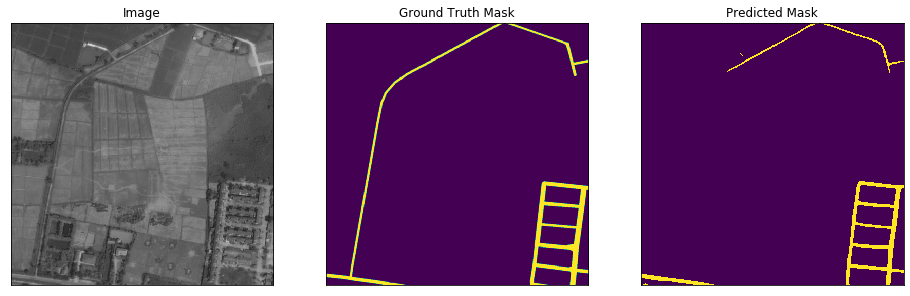

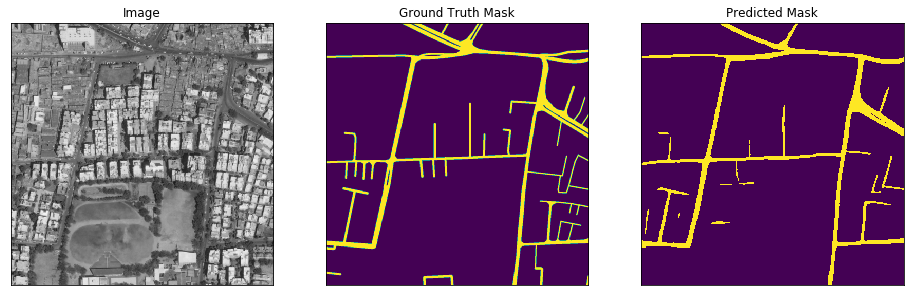

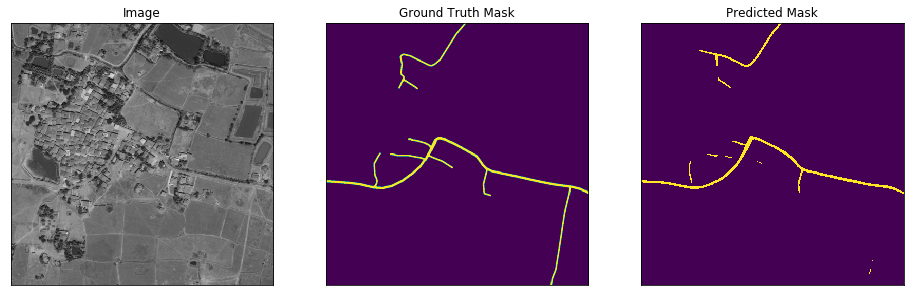

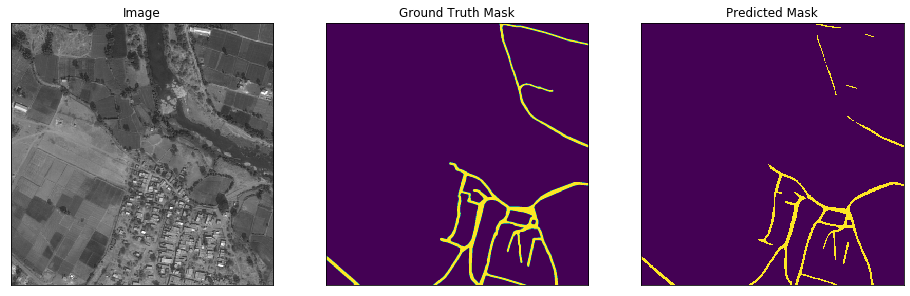

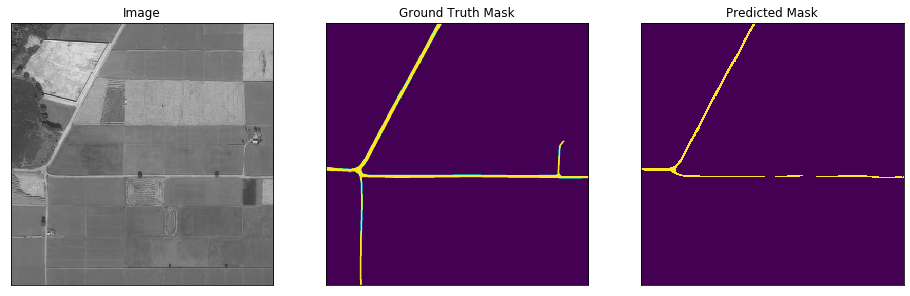

In [9]:
model_path = '/content/drive/My Drive/best_model_unet.pth'
model = torch.load(model_path)
DEVICE = 'cuda:0'
for i in range(5):
    n = np.random.choice(len(test_dataset))
    #print(test_dataset_vis[n][0])
    # image_vis = (test_dataset_vis[n][0]).numpy()
    # image_vis = image_vis.astype('uint8')
    # image_vis = np.transpose(image_vis, (1, 2, 0))

    #image_vis = test_dataset[n][0].astype('unit8')
    image, gt_mask = test_dataset[n]
    image = image.numpy()

    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    image = np.transpose(image, (1, 2, 0))   
    visualize(
        image=image, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )